In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import pymorphy2
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from utils.text_data_transformation import remove_stop_words
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
path_to_subdialog_keywords = os.path.join("data", "processed_dialog_files", "subdialog_keywords.csv")
path_to_save_result_csv = os.path.join("data", "processed_dialog_files", "subdialogs_topics2.csv")

D:\my_work\programming\telegram-dialogs-analysis\utils\text_data_transformation.py:251: DeprecationWarning: invalid escape sequence \-
  "\-\s\r\n\s{1,}|\-\s\r\n|\r\n", "", msg


In [2]:
# 0) Firstly, run tf_idf_for_subdialogs.ipynb to get subdialog_keywords.csv file
df = pd.read_csv(path_to_subdialog_keywords)

In [3]:
# DO NOT delete this part, because it is a method to use jsons for this code!!!!!!!!!

# # Import Dataset
# path_to_articles = '../static/ukr_articles'
# data = pd.read_csv(path_to_articles, sep = ';', header = None)
#
# LANGUAGE = "ua"
# stop_words = remove_stop_words(data, LANGUAGE, "get_stop_words")
#
# # write your number of rows to analyse. max == 695,
# # but to clean and analyse 30 rows is spending 6 minutes
# df = pd.DataFrame(data[:20])
#
# df.columns = ["id", "title", "en_title", "content", "date", "source_url",
#                   "article_url"]
# # df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# # print(df.target_names.unique())
# df.head()


In [4]:
# Convert to list
data = df.doc.values.tolist()

# # Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#
# # Remove new line characters
# data = [re.sub('\s+', ' ', sent) for sent in data]
#
# # Remove distracting single quotes
# data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


[nan]


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['nan']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['nan']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

def lemmatization(data, lang, cube):
    """

    :param lang: "ru", "ua" or "en"
    :param cube: only for "ua"an object after these commands cube = Cube(verbose=True); cube.load("uk")
    :return: cleaned text from synonyms
    """
    lemmas = []
    for i in range(len(data)):
        data[i] = " ".join(data[i])

    data = ". ".join(data)

    if lang == "ru":
        lemmas = " ".join(pymorphy2.MorphAnalyzer().parse(np.unicode(word))[0].normal_form for word in msg.split())

    elif lang in ("ua", "en"):
        sentences = cube(data)

        for sentence in sentences:  # note we selected the first sentence (sentence[0])
            sentence_lemma = []
            for entry in sentence:
                sentence_lemma.append(entry.lemma)

            lemmas.append(sentence_lemma)

    return lemmas

In [8]:
from cube.api import Cube

# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams)

# If you have unlemmatized text data, so uncomment it !!!!!

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm')
# # cube = Cube(verbose=True)
# # cube.load("en")
#

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
# data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# cube = ""
# if LANGUAGE == "ua":
#     cube = Cube(verbose=True)
#     cube.load("uk")
#
# elif LANGUAGE == "en":
#     cube = Cube(verbose=True)
#     cube.load("en")

# data_lemmatized = lemmatization(data_words_bigrams, LANGUAGE, cube)
data_lemmatized = data_words_bigrams


[['nan'], ['тут', 'мав', 'би', 'бути', 'жарт', 'про', 'те', 'якии', 'ти', 'гарячии', 'але', 'иого', 'не', 'придумав'], [], ['nan'], ['ну', 'там', 'не', 'шибко', 'гаряче', 'тобі', 'скажу'], ['ти', 'закинув', 'зараз', 'щоб', 'він', 'розігрівся', 'трохи', 'це', 'ои', 'маю', 'надію', 'hangouts', 'витягне', 'https', 'meet', 'google', 'com', 'uht', 'fozh', 'ffw', 'зустріч', 'першим', 'курсом', 'якщо', 'хтось', 'захоче', 'окрім', 'першого', 'курсу', 'то', 'також', 'долучаитесь', 'відписав', 'також', 'маю', 'все', 'знаишла', 'дякую', 'всім', 'маю', 'теж', 'маю'], ['не', 'відписує', 'мені', 'боико', 'сюдячи', 'інстаграму', 'привіт', 'хтось', 'має', 'зараз', 'біля', 'себе', 'останніи', 'форбс', 'pypi', 'org', 'ліба', 'джанго', 'допомагати', 'проблем', 'сторона', 'бекенд', 'фіксити'], ['nan'], ['загадка', 'веб', 'девелопмент', 'хтось', 'знати', 'робити', 'cors', 'police', 'access', 'control', 'allow', 'origin', 'допомагати', 'сторона', 'фронт', 'плагіна', 'розширення', 'ааааа', 'вдягнути', 'шапоч

In [9]:
print(data_lemmatized[:1])
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[['nan']]
[[(0, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('nan', 1)]]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"десь" + 0.024*"великии" + 0.016*"навчання" + 0.000*"почати" + '
  '0.000*"обід" + 0.000*"один" + 0.000*"переключитися" + 0.000*"вкладець" + '
  '0.000*"залишати" + 0.000*"приєднуватися"'),
 (1,
  '0.143*"добре" + 0.073*"ласка" + 0.071*"працювати" + 0.056*"людина" + '
  '0.044*"варто" + 0.030*"увесь" + 0.026*"сказати" + 0.024*"проблем" + '
  '0.023*"робота" + 0.023*"останніи"'),
 (2,
  '0.013*"він" + 0.010*"зустріч" + 0.000*"оон" + 0.000*"документ" + '
  '0.000*"декларація" + 0.000*"маибутніи" + 0.000*"щодо" + 0.000*"формат" + '
  '0.000*"bit" + 0.000*"основнии"'),
 (3,
  '0.048*"чекати" + 0.048*"список" + 0.005*"брат" + 0.005*"вірити" + '
  '0.004*"андрія" + 0.001*"подія" + 0.001*"пан" + 0.000*"відповідь" + '
  '0.000*"факт" + 0.000*"довго"'),
 (4,
  '0.165*"треба" + 0.134*"потрібнии" + 0.097*"писати" + 0.078*"якии" + '
  '0.052*"іншии" + 0.019*"команда" + 0.015*"наикращии" + 0.008*"досвід" + '
  '0.005*"шукати" + 0.004*"заиматися"'),
 (5,
  '0.091*"після" + 0.067*"можли

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -21.789185195624235

Coherence Score:  0.42777651933833133


## Visualize the topics-keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.330003  0.019559       1        1  15.407087
1      0.019688  0.032923       2        1  12.023303
19    -0.002402 -0.307024       3        1   8.401270
12     0.024240  0.019794       4        1   7.759522
4      0.021554  0.026199       5        1   6.857329
15     0.016397  0.030820       6        1   6.763164
14     0.023827  0.019493       7        1   6.122878
17     0.023800  0.021908       8        1   5.716687
13     0.023334  0.018079       9        1   5.421037
5      0.021749  0.015753      10        1   5.086157
8      0.022758  0.017175      11        1   4.597249
18     0.021274  0.015240      12        1   3.660934
11     0.019828  0.013691      13        1   3.066916
10     0.016480  0.010599      14        1   2.389583
9      0.014629  0.009031      15        1   1.571677
7      0.014941  0.009289      16        1   1.456860
3      0.013970  0.008487      17        1   1.256545
0      0.012830  0.007554      18        1   1.217580
2      0.010957  0.006040      19        1   0.813864
6      0.010151  0.005392      20        1   0.410361, topic_info=     Category         Freq       Term        Total  loglift  logprob
0     Default  1495.000000        nan  1495.000000     30.0  30.0000
57    Default   700.000000       якщо   700.000000     29.0  29.0000
137   Default   538.000000   дякувати   538.000000     28.0  28.0000
167   Default   251.000000       може   251.000000     27.0  27.0000
90    Default   223.000000      знати   223.000000     26.0  26.0000
...       ...          ...        ...          ...      ...      ...
2072  Topic20     0.011439  виглядати     1.384286      0.7  -8.7317
2074  Topic20     0.011439       лицо     1.384308      0.7  -8.7317
2043  Topic20     0.011439      право     1.384327      0.7  -8.7317
2034  Topic20     0.011439   богослов     1.384286      0.7  -8.7317
2035  Topic20     0.011439      крила     1.384285      0.7  -8.7317

[1660 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
21        4  0.954070        com
492       4  0.903946  instagram
0         1  0.998949        nan
155      17  0.460239     андрія
309       6  0.902307        аха
...     ...       ...        ...
14        5  0.989001       якии
477      14  0.695593      якраз
57        3  0.997691       якщо
609       5  0.976910      іншии
391      11  0.568869      іхати

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 2, 20, 13, 5, 16, 15, 18, 14, 6, 9, 19, 12, 11, 10, 8, 4, 1, 3, 7])

In [15]:
# TODO: in README.md
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path(you should write here full path to file,
# not relative)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('nan', 0.3523809523809524),
   ('зрозуміти', 0.02857142857142857),
   ('що', 0.02585034013605442),
   ('група', 0.024489795918367346),
   ('виходити', 0.017687074829931974),
   ('интерві', 0.014965986394557823),
   ('якраз', 0.013605442176870748),
   ('шкода', 0.009523809523809525),
   ('починатися', 0.00816326530612245),
   ('згадати', 0.006802721088435374)]),
 (15,
  [('ugs', 0.04755784061696658),
   ('хтось', 0.032133676092544985),
   ('один', 0.02699228791773779),
   ('кімната', 0.016709511568123392),
   ('напити', 0.016709511568123392),
   ('test', 0.016709511568123392),
   ('бліно', 0.012853470437017995),
   ('дедлаин', 0.011568123393316195),
   ('ситуація', 0.010282776349614395),
   ('віталік', 0.010282776349614395)]),
 (0,
  [('тест', 0.08450704225352113),
   ('школа', 0.03201024327784891),
   ('камера', 0.029449423815621),
   ('пити', 0.026888604353393086),
   ('список', 0.024327784891165175),
   ('виити', 0.020486555697823303),
   ('ахаха', 0.020486555697823303),
   

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

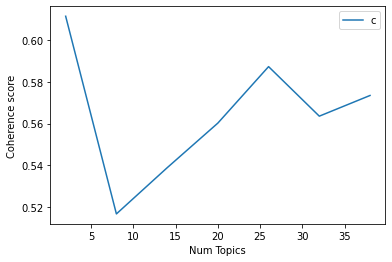

In [18]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6112
Num Topics = 8  has Coherence Value of 0.5169
Num Topics = 14  has Coherence Value of 0.5389
Num Topics = 20  has Coherence Value of 0.5602
Num Topics = 26  has Coherence Value of 0.5872
Num Topics = 32  has Coherence Value of 0.5635
Num Topics = 38  has Coherence Value of 0.5734


In [20]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.062*"людина" + 0.046*"робити" + 0.031*"дуже" + 0.027*"треба" + '
  '0.022*"день" + 0.019*"мати" + 0.018*"могти" + 0.017*"проблема" + '
  '0.017*"дивитися" + 0.016*"щось"'),
 (1,
  '0.032*"наш" + 0.026*"свіи" + 0.021*"змогти" + 0.020*"можливість" + '
  '0.018*"щодо" + 0.018*"ваш" + 0.017*"украінськии" + 0.017*"форма" + '
  '0.017*"команда" + 0.012*"світ"'),
 (2,
  '0.045*"один" + 0.031*"давати" + 0.026*"новии" + 0.025*"знаити" + '
  '0.021*"річ" + 0.021*"говорити" + 0.018*"викладач" + 0.018*"якщо" + '
  '0.017*"кожнии" + 0.014*"частина"'),
 (3,
  '0.036*"якиись" + 0.035*"дуже" + 0.034*"взагалі" + 0.030*"тип" + '
  '0.027*"норм" + 0.023*"проект" + 0.021*"грн" + 0.016*"раз" + '
  '0.016*"пропонувати" + 0.015*"вирішити"'),
 (4,
  '0.082*"може" + 0.069*"треба" + 0.065*"хтось" + 0.058*"знати" + '
  '0.049*"зробити" + 0.045*"казати" + 0.023*"аха" + 0.017*"купити" + '
  '0.016*"дівчина" + 0.015*"останніи"'),
 (5,
  '0.085*"курс" + 0.040*"працювати" + 0.034*"робота" + 0.026*"привіт" +

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5311,"людина, робити, дуже, треба, день, мати, могти...",річчя день народження івана павнути зберести...
1,1.0,0.5026,"наш, свіи, змогти, можливість, щодо, ваш, укра...",хееей зацікавлений саморозвиток відчувати ре...
2,2.0,0.4577,"один, давати, новии, знаити, річ, говорити, ви...",новий викладач додати один якщо говорити фо...
3,3.0,0.4201,"якиись, дуже, взагалі, тип, норм, проект, грн,...",поправити пропонувати залишити імейл добров...
4,4.0,0.2623,"може, треба, хтось, знати, зробити, казати, ах...",general штоль логічніше написати бесід воло...


In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv(path_to_save_result_csv, index=False)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"nan, якби, пам_ятати, приєднуватися, дедлаин, ...",196.0,0.0466
1.0,0.0,"людина, робити, дуже, треба, день, мати, могти...",154.0,0.0366
2.0,0.0,"людина, робити, дуже, треба, день, мати, могти...",203.0,0.0483
3.0,14.0,"nan, калькулятор, класнии, читати, шкода, кара...",173.0,0.0411
4.0,14.0,"nan, калькулятор, класнии, читати, шкода, кара...",206.0,0.0490
...,...,...,...,...
4202.0,19.0,"дякувати, завтра, побачити, основнии, добрии, ...",NaN,NaN
4203.0,4.0,"може, треба, хтось, знати, зробити, казати, ах...",NaN,NaN
4204.0,7.0,"якщо, тест, питання, після, тобто, відповідь, ...",NaN,NaN
4205.0,4.0,"може, треба, хтось, знати, зробити, казати, ах...",NaN,NaN
